# Introduction

This notebook contains all data collection, modeling, and simulation code necessary to re-create the results found in Karst, Dralle, and Muller, "On the effect of non-linear recessions on low flow variability: Diagnostic of an analytical model for annual flow duration curves", WRR 2019. 

## Helper Functions

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from peakdetect import peakdet as peakdet
from scipy.optimize import curve_fit
from scipy import special
import random

import pickle
import urllib

import datetime

import scipy

import warnings
warnings.filterwarnings('ignore')

### AFDC Helper Functions

In [2]:
def nchoosek(n,k):
    return np.math.factorial(n)/np.math.factorial(k)/np.math.factorial(n-k)

def cdfOrderPrime(qPrime,g,m,r,n):
    return scipy.special.betainc(r, n-r+1, cdfQwPrime(qPrime,g,m))

def pdfOrderPrime(qPrime,g,m,r,n):
    return r*nchoosek(n,r)*cdfQwPrime(qPrime,g,m)**(r-1)*(1-cdfQwPrime(qPrime,g,m))**(n-r)*pdfQwPrime(qPrime,g,m)

def cdfQw(q, g, m):
    return special.gammainc(m, g*q) # this inc. gamma is already normalized/regularized

def pdfQw(q, g, m):
    return g**m/special.gamma(m)*q**(m-1)*np.exp(-g*q)

def cdfQwPrime(qPrime, g, m):
    return special.gammainc(m,m*qPrime)

def pdfQwPrime(qPrime, g, m):
    return pdfQw(qPrime*m/g,g,m)*m/g # final *m/g accounts for chain rule
 
def cdfAF(q, a, b):
    return special.gammainc(a,b*q)

def pdfAF(q, a, b):
    return b**a*q**(a-1)*np.exp(-b*q)/special.gamma(a)

### Monte Carlo Helper Functions

In [3]:
def streamflowMonteCarlo(params,y=100.,n=100.,dt=1/24.,linear=True):
    '''
        Input: Parameters for linear or nonlinear recession model, together with the number of 'years' [y], number of days per year [n], and maximum time step [dt]
        
        Output: List of average daily streamflows 
    '''       
    # params is a dictionary containing keys [k,gq,L] if linear=True and [a,b,gw,L] if linear=False
    
    dtMax = dt
    
    Q = [1e-6]
    T = [0]
    
    q = Q[0]
    t = T[0]
    currYear = 0
    while t < y*n:
        if currYear*n < np.floor(t):
            currYear += 1
        
        # compute rate of change of flow
        if linear: dqdt = -params['k']*q
        else: dqdt = -params['a']*q**params['b']        
        
        dt = dtMax
        # ensure q does not change by more than 50% of its current value
        if q + dqdt*dt < 0: 
            dt = np.abs(0.5*q/dqdt)
        
        # if a precipitation event occurs, sample a streamflow increment from appropriate distribution
        increment = 0.0
        if np.random.uniform() > np.exp(-params['L']*dt):
            if linear: increment = streamflowIncrementLinear(params['gq'])
            else: increment  = streamflowIncrementNonlinear(q,params['a'],params['b'],params['gw'])
        
        # Euler update
        q += dqdt*dt + increment
        t += dt

        # overshoot below 0 should not be possible with safe time step, but if it happens to...
        # put q very close to zero
        if q < 0: q = 1e-9
        
        Q.append(q)
        T.append(t)
        
        if np.isnan(q):
            print('streamflowMonteCarlo: numerical instability')
            return
    
    # average all flow values in each day, and return the associated list of streamflows 
    tmp = pd.DataFrame({'q':Q,'t':T})
    tmp['day'] = np.floor(tmp.t)
    Q = list(tmp.groupby('day').mean().q)
    
    return Q
     
def streamflowIncrementLinear(g):
    return np.random.exponential(1./g)
    
def streamflowIncrementNonlinear(q1,a,b,gw):   
    beta = 2.-b
    alpha = 1./(a*beta)
    
    increment = np.nan
    while np.isnan(increment):
        F = np.random.uniform()
        increment = (q1**beta - np.log(1.-F)/(alpha*gw))**(1./beta) - q1   

    return increment

### Data Helper Functions

In [4]:
def getFlow(site):
    '''
        Input: USGS gage number
        
        Output: pandas data frame of volumetric streamflow (over period of record at the gage) indexed by datetime
    '''
    
    try: 
        f = open('data_flow/'+ site + '.txt','r')
    except: 
        site = str(site)

        url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=' + site + '&referred_module=sw&period=&begin_date=1900-01-01&end_date=2017-01-01'

        response =  urllib.urlopen(url)
        content = response.read().decode('utf-8')
        
        

        f = open('data_flow/' + site + '.txt','w')
        f.write(content)
        f.close()

    count = 0
    for line in open('data_flow/'+ site +'.txt','r').readlines():
        if line[0] == '#': 
            count += 1
        else:
            break

    df = pd.read_csv('data_flow/'+ site+'.txt', header=count, delimiter='\t')

    q_col = next(col for col in df.columns if col.endswith('00060_00003'))
    
    df.rename(columns={q_col: 'q', 'datetime':'date'}, inplace=True)
    df = df[['date','q']]
    df = df.iloc[1:,:]
    df = df.dropna()

    df.date = pd.to_datetime(df.date)
    df.q = pd.to_numeric(df.q)
    
    df.index = pd.to_datetime(df.date)
    
    return df

def getSiteInfo(site):
    '''
        Input: USGS gage number
        
        Output: pandas data frame of site name, lat, lon, and area (m^2)
    '''    
    try: 
        f = open('data_site/'+ site + '.txt','r')
    except: 
        site = str(site)

        url = 'https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=' + str(site) + '&siteOutput=expanded'

        response =  urllib.urlopen(url)
        content = response.read().decode('utf-8')

        
        
        f = open('data_site/' + site + '.txt','w')
        f.write(content)
        f.close()

    count = 0
    for line in open('data_site/'+ site+'.txt','r').readlines():
        if line[0] == '#': 
            count += 1
        else:
            break

    df = pd.read_csv('data_site/'+ site+'.txt', header=count, delimiter='\t')

    df = df.iloc[1:,:]
    
    df = df[['site_no', 'station_nm', 'lat_va', 'long_va', 'drain_area_va']]
    df.rename(columns={'site_no': 'gage', 
                       'station_nm':'name', 
                       'lat_va':'lat', 
                       'long_va':'lon',
                       'drain_area_va':'areaSqM'}, inplace=True)
    
    df.name = [name.title() for name in df.name]
    df.areaSqM = pd.to_numeric(df.areaSqM)
    df.areaSqM *= 2.59e+6
    
    df.set_index('gage',drop=True,inplace=True)
    
    return df 

def getAFDCs(df,verbose=False,start='12-01',stop='02-28'):
    '''
        Input: Pandas data frame of flow values indexed by datetime
        
        Output: Pandas data frame of sorted flows by water year
    '''    
    
    years = list(set(df.index.year))
    
    afdcs = []
    for year in years:
        tmp = df[str(year)+'-'+start:str(year+1)+'-'+stop]
    
        # if a year is missing too many data points, discard it and move on
        if len(tmp) < 90:
            if verbose: print('Too short!')
            continue
        
        afdcs.append(pd.DataFrame({'wy':year,'q':sorted(tmp.q)[:90],'r':np.linspace(1,90,90),'s':90-np.linspace(1,90,90)}))
        
    return pd.concat(afdcs)

def getBotterParams(d,
    season='winter',
    option=1,
    start = 0,
    selectivity = 200,
    ante = 10,
    window = 3,
    minLen = 5,
    alph = .9,
    linear=True):   
    '''
        Input: Pandas data frame of flow values indexed by datetime
        
        Output: Recession parameters (k if linear=True, and (a,b) if linear=False), 
                preciptiation pamaters (lambda and gamma if linear = True, lambda = linear=False)
    '''       
    

    popts = []
    tw = 365
    if season=='winter':
        tw = len(pd.date_range('12-2015', '3-2016'))
        d = d.q.loc[(d.index.month>=12)|(d.index.month<=2)].ffill()
    elif season=='spring': 
        tw = len(pd.date_range('3-2016', '6-2016'))
        d = d.q.loc[(d.index.month>=3)&(d.index.month<=5)] #.ffill()
    elif seasons=='summer':
        tw = len(pd.date_range('6-2016', '9-2016'))
        d = d.q.loc[(d.index.month>=6)&(d.index.month<=8)].ffill()
    elif seasons=='fall':
        tw = len(pd.date_range('9-2016', '12-2016'))
        d = d.q.loc[(d.index.month>=9)&(d.index.month<=11)].ffill()
    
    dates = d.index
    d = pd.DataFrame({'q':d.tolist()})

    selector = (d.q.max()-d.q.min())/selectivity
    [maxtab, mintab]=peakdet(d.q, selector)

    #initialize peaks
    d['peaks']=-1

    #get rid of peaks too close to the start
    if ante>2:
        maxtab = maxtab[maxtab[:,0].astype(int)>ante]
    else:
        maxtab = maxtab[maxtab[:,0].astype(int)>1]

    d.ix[maxtab[:,0].astype(int),'peaks']=maxtab[:,1]

    d['smooth']= pd.rolling_mean(d.q,window); d['smooth'][0:2] = d.q[0:2]
    d['Dunsmooth']= d.q.diff().shift(-1)
    d['DDsmooth']=d['smooth'].diff().shift(-1).diff().shift(-1)
    d['DDunsmooth'] = d.q.diff().shift(-1).diff().shift(-1)
    d = d[:-2]

    #boolean vector for recession periods 
    if option==0:
        d['choose']=d['Dunsmooth']<=0
    else:
        d['choose']=(d['Dunsmooth']<=0) & ((d['DDsmooth']>=0)|(d['DDunsmooth']>=0))

    datesMax = d.ix[d['peaks']>0].index;
    
    for i in np.arange(len(datesMax)-1):
        recStart = datesMax[i]; peak1 = datesMax[i]+1; peak2 = datesMax[i+1]
        recEnd = d[peak1:peak2][d[peak1:peak2]['choose']==False].index[0]
        if (len(d[recStart:recEnd])<minLen) | (np.any(d.q[recStart:recEnd]<0)):
            continue
        t = np.arange(len(d.q[recStart:recEnd]))
        q0 = d.q[recStart]

        if linear: 
            def func(t,k): return q0*np.exp(-k*t) 
        else: 
            def func(t,a,b): return (q0**(1.-b) - a*(1.-b)*t)**(1./(1-b))        
        
        try:
            if linear: p0 = [.1]
            else: p0 = [0.001,1.5]
            popt, cov = curve_fit(func,t,d.q[recStart:recEnd],p0=p0)

        except RuntimeError:
#             print('Error encountered in fitting')
            continue

        popts.append(popt)

    lam = len(peakdet(d.q, 10e-10)[0])/float(len(d.q))       
    if linear:
        k = np.median([popt[0] for popt in popts])
        meanQ = np.mean(d.q)
        gam = lam/(k*meanQ)

        return (k, lam, gam)
    else:
        B = [popt[1] for popt in popts]
        b = np.median(B)
            
        A = []
        for i in np.arange(len(datesMax)-1):
            recStart = datesMax[i]; peak1 = datesMax[i]+1; peak2 = datesMax[i+1]
            recEnd = d[peak1:peak2][d[peak1:peak2]['choose']==False].index[0]
            if (len(d[recStart:recEnd])<minLen) | (np.any(d.q[recStart:recEnd]<0)):
                continue
            t = np.arange(len(d.q[recStart:recEnd]))
            q0 = d.q[recStart]

            def func(t,a): return (q0**(1.-b) - a*(1.-b)*t)**(1./(1-b))                    
            try:
                p0 = [1]
                popt, cov = curve_fit(func,t,d.q[recStart:recEnd],p0=p0)    
                A.append(popt[0])
            except: 
                pass
            
        a = np.median(A)
        
        return (a,b,lam)

## Main Analysis

In [5]:
gages = ['11475560','02398000','14325000','03602500', '12048000']
names = {'11475560':'Elder Creek', 
         '02398000':'Chattooga River',
         '14325000':'South Fork Coquille',
         '03602500':'Piney River',
         '12048000':'Dungeness River'}

In [6]:
# we will add the relevant parameters to this growing list as we iterate through the gages
params = []
for gage in gages:
    info = getSiteInfo(gage)
    print(gage, info.loc[gage,'name'])
    
    df = getFlow(gage)
    df = df.loc[df.index.year <= 2016]
    df.q += 1e-12 # having flow exactly equal to zero can cause problems with logs
    df.q *= 2446.58 # cfs -> m^3/d
    df.q /= info.loc[gage,'areaSqM']

    ## GET BOTTER AND CASTELLARIN PARAMS
    print('\tComputing Botter parameters...')    
    
    (k,L,g) = getBotterParams(df)
    (a,b,L) = getBotterParams(df,linear=False)
    
    gw = g*k
    beta = 2.-b
    alpha = 1./(a*beta)    
    
    m     = L/k
    meanQ = m/g
    varianceQ = m/g**2    

    print('\tComputing Castellarin parameters...')
    tw = 92
    r = np.linspace(1,tw,tw) # we'll need this below...
    
    meanAF = meanQ
    varianceAF = 0.0
    for i in range(tw):
        for j in range(tw):
            tau = np.abs(i-j)
            varianceAF += np.exp(-k*tau)*varianceQ

    varianceAF /= tw**2

    aAF = meanAF**2/varianceAF        
    bAF = meanAF/varianceAF    

    # we'll save all the parameters to one big data frame later
    params.append([gage, k, L, g, meanQ, varianceQ, meanAF, varianceAF, aAF, bAF, a, b])    
    
    ## MONTE CARLO SIMULATIONS
    y = 1000. # number of periods
    n = 100 # length of each period
    dt = 1/24. # time step -- this might be shorter in some simulations
    
    ### LINEAR MC
    print('\tRunning linear Monte Carlo simulation...')  
    print('\t\tg = %f'%(g))    
    print('\t\tk = %f'%(k))
    print('\t\tL = %f'%(L))    
    
    Q = streamflowMonteCarlo({'k':k,'L':L,'gq':g},y,n,dt,linear=True)   
    mc = pd.concat([pd.DataFrame({'i':i,'q':sorted(Q[i*n:(i+1)*n]),'r':np.linspace(1,n,n),'s':n-np.linspace(1,n,n)}) for i in range(int(y))])    
    
    f = open('data_results/'+gage+'_mc_linear.csv','w')
    mc.to_csv(f)
    f.close()      
    
    ### NONLINEAR MC
    print('\tRunning nonlinear Monte Carlo simulation...')
    print('\t\ta = %f'%(a))    
    print('\t\tb = %f'%(b))
    print('\t\talpha = %f'%(alpha))    
    print('\t\tbeta = %f'%(beta))   
    print('\t\tg = %f'%(g))    
    print('\t\tk = %f'%(k))   
    print('\t\tL = %f'%(L)) 
    
    Q = streamflowMonteCarlo({'a':a,'b':b,'gw':g*k,'L':L},y,n,dt,linear=False)   
    mc = pd.concat([pd.DataFrame({'i':i,'q':sorted(Q[i*n:(i+1)*n]),'r':np.linspace(1,n,n),'s':n-np.linspace(1,n,n)}) for i in range(int(y))])    
    
    f = open('data_results/'+gage+'_mc_nonlinear.csv','w')
    mc.to_csv(f)
    f.close()   
    
    ## AFDCs
    print('\tComputing AFDCs...')
    afdc = getAFDCs(df)
    afdc['gage'] = gage
    
    f = open('data_results/'+gage+'_afdc.csv','w')
    afdc.to_csv(f)
    f.close()     
    
    ## ORDER STATISTICS
    print('\tComputing order statistics...')    
    qPrime = np.logspace(-9,1,2000)
    q = qPrime*meanQ
    dq = qPrime[1:] - qPrime[:-1]

    tmp = []
    for i,rr in enumerate(r):
        cdfOrder = [np.trapz(pdfOrderPrime(qPrime, g, m, rr, tw)*cdfAF(qq/qPrime, aAF, bAF),qPrime) for qq in q]
        pdfOrder = [0] + list(np.diff(cdfOrder)/dq)
        tmp.append(pd.DataFrame({'r':rr,'s':tw-rr+1,'q':q,'F':cdfOrder, 'f':pdfOrder}))
    order = pd.concat(tmp)  
    order['gage'] = gage
    
    f = open('data_results/'+gage+'_order_stats.csv','w')
    order.to_csv(f)
    f.close()    
    
params = pd.DataFrame(params, columns=['gage','k','L','g','meanQ','varianceQ','meanAF','varianceAF','aAF','bAF','a','b'])
f = open('data_results/'+gage+'_params.csv','w')
params.to_csv(f)
f.close()   

('11475560', 'Elder C Nr Branscomb Ca')
	Computing Botter parameters...
	Computing Castellarin parameters...
	Running linear Monte Carlo simulation...
		g = 50.101466
		k = 0.254975
		L = 0.109389
	Running nonlinear Monte Carlo simulation...
		a = 1.202908
		b = 1.374767
		alpha = 1.329614
		beta = 0.625233
		g = 50.101466
		k = 0.254975
		L = 0.109389
	Computing AFDCs...
	Computing order statistics...
('02398000', 'Chattooga River At Summerville, Ga')
	Computing Botter parameters...
	Computing Castellarin parameters...
	Running linear Monte Carlo simulation...
		g = 236.803436
		k = 0.238367
		L = 0.148484
	Running nonlinear Monte Carlo simulation...
		a = 280.014123
		b = 2.245059
		alpha = -0.014573
		beta = -0.245059
		g = 236.803436
		k = 0.238367
		L = 0.148484
	Computing AFDCs...
	Computing order statistics...
('14325000', 'South Fork Coquille River At Powers, Or')
	Computing Botter parameters...
	Computing Castellarin parameters...
	Running linear Monte Carlo simulation...
		g 

## Plot Results

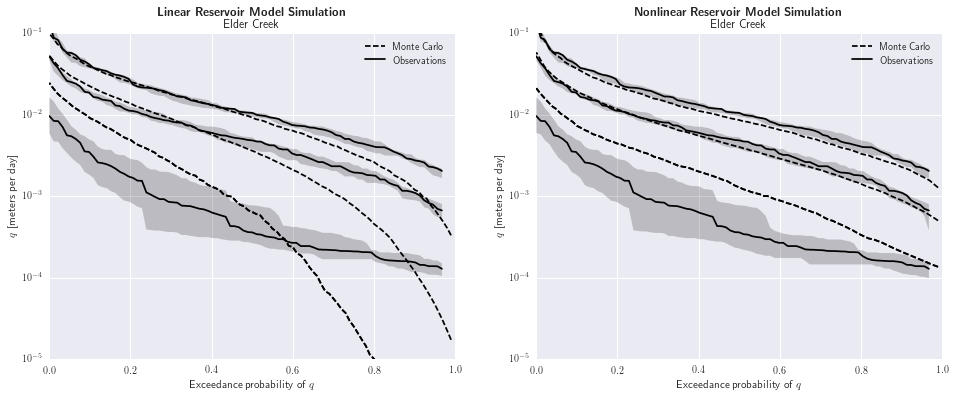

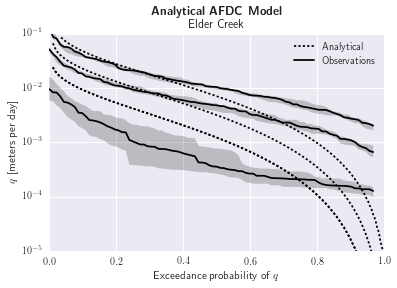

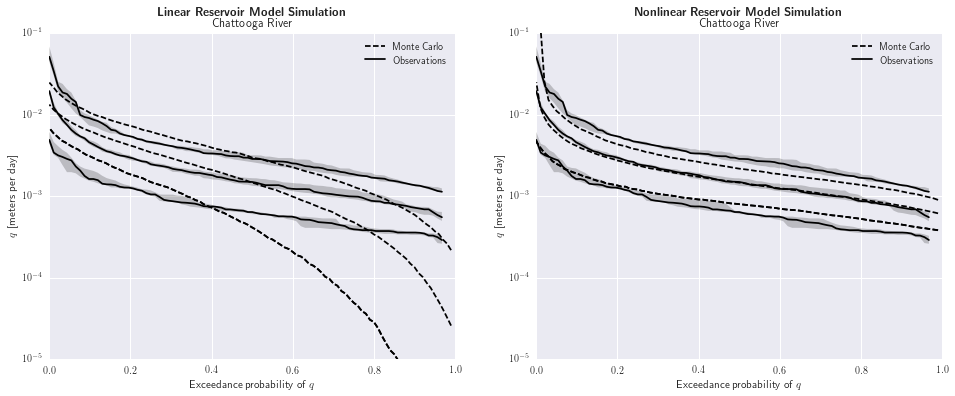

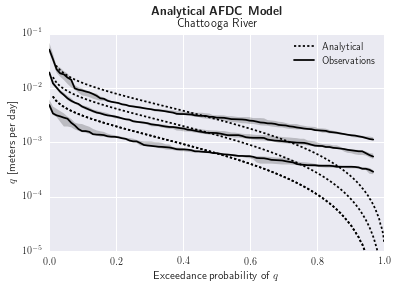

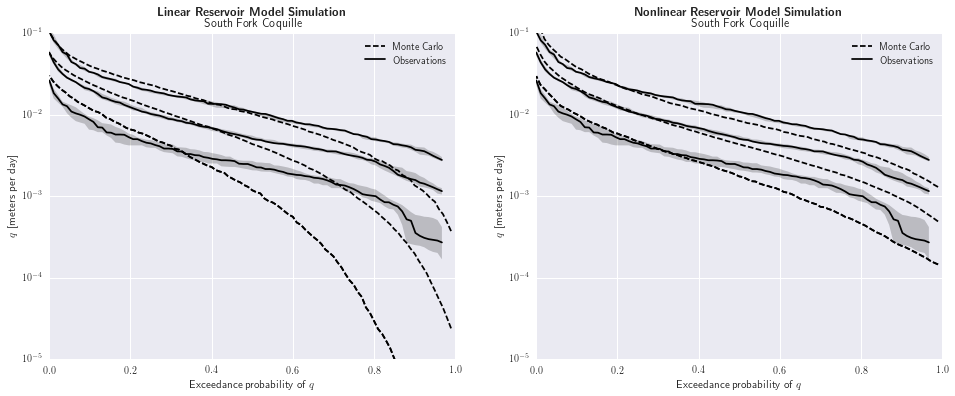

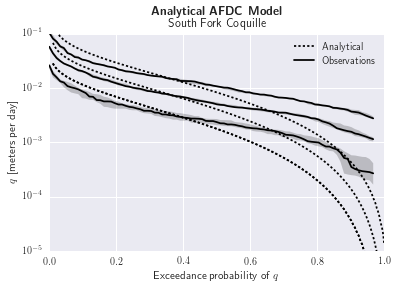

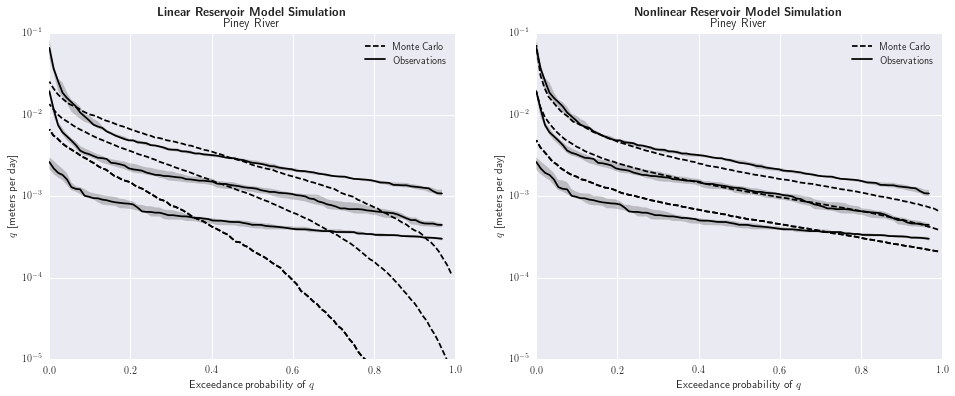

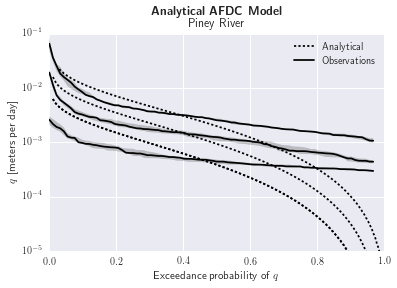

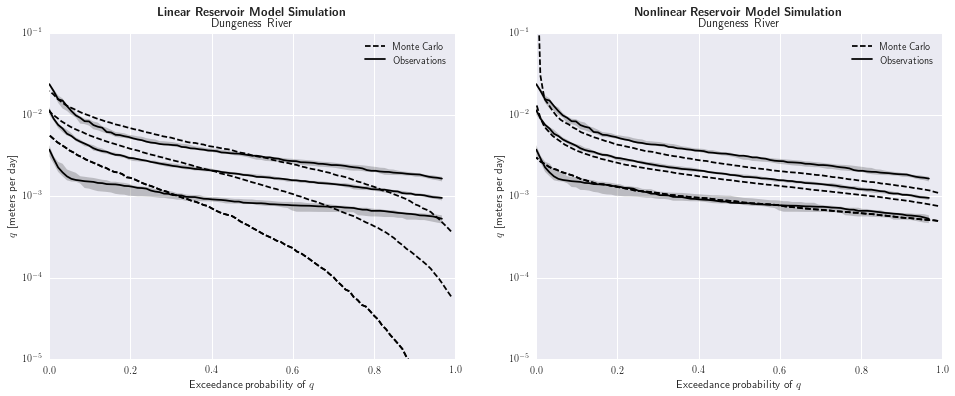

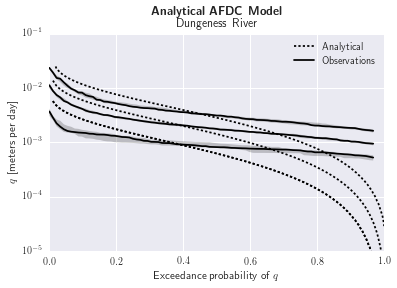

In [7]:
%matplotlib inline
def plotResult(gage,observations=True,predictions=True,mcLinear=True,mcNonlinear=False):
    from matplotlib import rc
    rc('text', usetex=True)
    info = getSiteInfo(gage)
    order = pd.read_csv(open('data_results/' +gage + '_order_stats.csv','r'))
    afdc = pd.read_csv(open('data_results/' + gage + '_afdc.csv','r'))
    n = order.r.max()
    
    plt.figure(figsize=(16,6))
    
    filename = str(gage) + '_lin_nonlin_combined.pdf'
    
    plt.subplot(1,2,1)

    # load both afdc and mc... ,, 
    afdc['Duration'] = afdc.s/n
    mc = pd.read_csv(open('data_results/' + gage + '_mc_linear.csv','r'))     
    n = mc.r.max()
    r = np.linspace(1,n,n)    
    
    # plot the first of both...
    plt.plot((n-r)/n,mc.groupby(by='r').quantile(0.05).q,'k--',label='5th percentile (MC)')
    sns.tsplot(data=afdc,time='Duration',value='q',unit='wy',ci=68, color='k',estimator=lambda x, axis: np.percentile(x,5,axis))
    
    # build the legend ...
    h = plt.gca().get_lines()
    plt.legend(handles=h, labels=['Monte Carlo','Observations'])
    
    # and then plot the rest...
    sns.tsplot(data=afdc,time='Duration',value='q',unit='wy',ci=68, color='k',estimator=lambda x, axis: np.percentile(x,50,axis))
    sns.tsplot(data=afdc,time='Duration',value='q',unit='wy',ci=68, color='k',estimator=lambda x, axis: np.percentile(x,95,axis))

    plt.plot((n-r)/n,mc.groupby(by='r').quantile(0.05).q,'k--',label='5th percentile (MC)')
    plt.plot((n-r)/n,mc.groupby(by='r').quantile(0.5).q,'k--',label='50th percentile (MC)')
    plt.plot((n-r)/n,mc.groupby(by='r').quantile(0.95).q,'k--',label='95th percentile (MC)')  
 
    plt.yscale('log')
    plt.xlim((0,1))
    plt.xlabel('Exceedance probability of $q$')

    plt.ylim((10e-6,10e-2))
    plt.ylabel('$q$ [meters per day]')
    
    plt.title(r'$\textbf{Linear Reservoir Model Simulation}$' + '\n' + names[gage])

    
    plt.subplot(1,2,2)
    n = order.r.max()
    afdc['Duration'] = afdc.s/n
    mc = pd.read_csv(open('data_results/' + gage + '_mc_nonlinear.csv','r'))  
    n = mc.r.max()
    r = np.linspace(1,n,n)
    
    plt.plot((n-r)/n,mc.groupby(by='r').quantile(0.05).q,'k--',label='5th percentile (MC)')
    sns.tsplot(data=afdc,time='Duration',value='q',unit='wy',ci=68, color='k',estimator=lambda x, axis: np.percentile(x,5,axis))
    
    
    h = plt.gca().get_lines()
    plt.legend(handles=h, labels=['Monte Carlo','Observations'])
    
    sns.tsplot(data=afdc,time='Duration',value='q',unit='wy',ci=68, color='k',estimator=lambda x, axis: np.percentile(x,50,axis))
    sns.tsplot(data=afdc,time='Duration',value='q',unit='wy',ci=68, color='k',estimator=lambda x, axis: np.percentile(x,95,axis))
    
    mc = pd.read_csv(open('data_results/' + gage + '_mc_nonlinear.csv','r'))  
    n = mc.r.max()
    r = np.linspace(1,n,n)
    plt.plot((n-r)/n,mc.groupby(by='r').quantile(0.05).q,'k--',label='5th percentile (MC)')
    plt.plot((n-r)/n,mc.groupby(by='r').quantile(0.5).q,'k--',label='50th percentile (MC)')
    plt.plot((n-r)/n,mc.groupby(by='r').quantile(0.95).q,'k--',label='95th percentile (MC)')  
        
    plt.yscale('log')
    plt.xlim((0,1))
    plt.xlabel('Exceedance probability of $q$')

    plt.ylim((10e-6,10e-2))
    plt.ylabel('$q$ [meters per day]')
    
    plt.title(r'$\textbf{Nonlinear Reservoir Model Simulation}$' + '\n' + names[gage])
    
    plt.savefig('figures/' + filename,bbox_inches='tight')
    
    
    plt.figure()
    info = getSiteInfo(gage)
    order = pd.read_csv(open('data_results/' +gage + '_order_stats.csv','r'))
    afdc = pd.read_csv(open('data_results/' + gage + '_afdc.csv','r'))
    n = order.r.max()
    afdc['Duration'] = afdc.s/n
    
    order['Duration'] = order.s/n
    p = order.loc[order.gage == int(gage)].pivot(index='q',columns='Duration',values='F')
    
    plt.figure()
    filename = str(gage) + '_model_afdc.pdf'

    c = plt.contour(p.columns,p.index,p,levels=[0.05],colors=['k'],linestyles=['dotted'])
    sns.tsplot(data=afdc,time='Duration',value='q',unit='wy',ci=68, color='k',estimator=lambda x, axis: np.percentile(x,5,axis))
    
    h = plt.gca().get_lines()
    plt.legend(handles=[c.collections[0],h[0]], labels=['Analytical','Observations'])    

    plt.contour(p.columns,p.index,p,levels=[0.05,.5,0.95],colors=['k','k','k'],linestyles=['dotted','dotted','dotted'])
    sns.tsplot(data=afdc,time='Duration',value='q',unit='wy',ci=68, color='k',estimator=lambda x, axis: np.percentile(x,50,axis))
    sns.tsplot(data=afdc,time='Duration',value='q',unit='wy',ci=68, color='k',estimator=lambda x, axis: np.percentile(x,95,axis))

    plt.yscale('log')
    plt.xlim((0,1))
    plt.xlabel('Exceedance probability of $q$')

    plt.ylim((10e-6,10e-2))
    plt.ylabel('$q$ [meters per day]')
    
    plt.title(r'$\textbf{Analytical AFDC Model}$' + '\n' + names[gage])
    
    plt.savefig('figures/' + filename,bbox_inches='tight')
    
for gage in gages:
    plotResult(gage)
    

## Drought Investigation

In [8]:
gage = '11475560'

info = getSiteInfo(gage)
print(gage, info.loc[gage,'name'])

df = getFlow(gage)
df = df.loc[df.index.year <= 2010] # ignore the drought years in the mid-2010's
df.q += 1e-12 # having flow exactly equal to zero can cause problems with logs
df.q *= 2446.58 # cfs -> m^3/d
df.q /= info.loc[gage,'areaSqM']

## GET BOTTER AND CASTELLARIN PARAMS
print('\tComputing Botter parameters...')    

(k,L,g) = getBotterParams(df)
(a,b,L) = getBotterParams(df,linear=False)

gw = g*k
beta = 2-b
alpha = 1/(a*beta)    

m     = L/k
meanQ = m/g
varianceQ = m/g**2    

print('\tComputing Castellarin parameters...')
tw = 92
r = np.linspace(1,tw,tw) # we'll need this below...

meanAF = meanQ
varianceAF = 0.0
for i in range(tw):
    for j in range(tw):
        tau = np.abs(i-j)
        varianceAF += np.exp(-k*tau)*varianceQ

varianceAF /= tw**2

aAF = meanAF**2/varianceAF        
bAF = meanAF/varianceAF    

print('\tRunning nonlinear Monte Carlo simulation...')  
print('\t\ta = %f'%(a))    
print('\t\tb = %f'%(b))
print('\t\talpha = %f'%(alpha))    
print('\t\tbeta = %f'%(beta))   
print('\t\tg = %f'%(g))    
print('\t\tk = %f'%(k))       

y = 1000.
n = 100
dt = 1/24.
Q = streamflowMonteCarlo({'a':a,'b':b,'gw':g*k,'L':L},y,n,dt,linear=False)   
mc = pd.concat([pd.DataFrame({'i':i,'q':sorted(Q[i*n:(i+1)*n]),'r':np.linspace(1,n,n),'s':n-np.linspace(1,n,n)}) for i in range(int(y))])    

f = open('data_results/'+gage+'_mc_nonlinear_no_drought.csv','w')
mc.to_csv(f)
f.close()       

# GET AFDCs
print('\tComputing AFDCs...')
afdc = getAFDCs(df)
afdc['gage'] = gage

f = open('data_results/'+gage+'_afdc_no_drought.csv','w')
afdc.to_csv(f)
f.close()     

## GET ORDER STATISTICS
print('\tComputing order statistics...')    
#     qPrime = np.linspace(1e-24,10,1000)
qPrime = np.logspace(-9,1,1000)
q = qPrime*meanQ
dq = qPrime[1:] - qPrime[:-1]

tmp = []
for i,rr in enumerate(r):
    cdfOrder = [np.trapz(pdfOrderPrime(qPrime, g, m, rr, tw)*cdfAF(qq/qPrime, aAF, bAF),qPrime) for qq in q]
    pdfOrder = [0] + list(np.diff(cdfOrder)/dq)
    tmp.append(pd.DataFrame({'r':rr,'s':tw-rr+1,'q':q,'F':cdfOrder, 'f':pdfOrder}))
order = pd.concat(tmp)  
order['gage'] = gage

f = open('data_results/'+gage+'_order_stats_no_drought.csv','w')
order.to_csv(f)
f.close()    

('11475560', 'Elder C Nr Branscomb Ca')
	Computing Botter parameters...
	Computing Castellarin parameters...
	Running nonlinear Monte Carlo simulation...
		a = 0.781950
		b = 1.274918
		alpha = 1.763736
		beta = 0.725082
		g = 48.298799
		k = 0.255297
	Computing AFDCs...
	Computing order statistics...


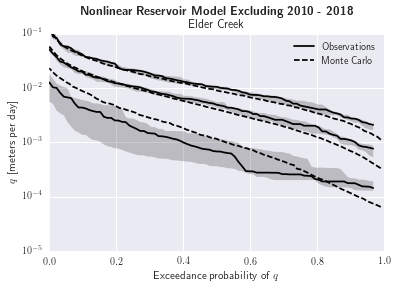

In [9]:
plt.figure()

afdc['Duration'] = afdc.s/tw
n = np.max(mc.r)
r = np.linspace(1,n,n)

sns.tsplot(data=afdc,time='Duration',value='q',unit='wy',ci=68, color='k',estimator=lambda x, axis: np.percentile(x,5,axis))
plt.plot((n-r)/n,mc.groupby(by='r').quantile(0.05).q,'k--',label='5th percentile (MC)')

h = plt.gca().get_lines()
plt.legend(handles=[h[0],h[1]], labels=['Observations','Monte Carlo']) 


sns.tsplot(data=afdc,time='Duration',value='q',unit='wy',ci=68, color='k',estimator=lambda x, axis: np.percentile(x,50,axis))
sns.tsplot(data=afdc,time='Duration',value='q',unit='wy',ci=68, color='k',estimator=lambda x, axis: np.percentile(x,95,axis))

plt.plot((n-r)/n,mc.groupby(by='r').quantile(0.5).q,'k--',label='50th percentile (MC)')
plt.plot((n-r)/n,mc.groupby(by='r').quantile(0.95).q,'k--',label='95th percentile (MC)')  

plt.yscale('log')
plt.xlim((0,1))
plt.ylim((10e-6,10e-2))
plt.title(r'\textbf{Nonlinear Reservoir Model Excluding 2010 - 2018}' + '\n' + 'Elder Creek')
plt.xlabel(r'Exceedance probability of $q$')
plt.ylabel(r'$q$ [meters per day]')
plt.savefig('figures/'+str(gage) + '_afdc_mcNonlinear_no_drought.pdf')